In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv', 'embeddings']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import time
pd.set_option('max_colwidth',400)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.utils.data
import random
import warnings
warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples.")
import re
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

Using TensorFlow backend.


In [3]:

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
sub = pd.read_csv('../input/sample_submission.csv')

In [5]:
max_features = 120000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(test['question_text'].values)
tk.fit_on_texts(full_text)

In [6]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

# Clean the text
train["question_text"] = train["question_text"].apply(lambda x: clean_text(x.lower()))
test["question_text"] = test["question_text"].apply(lambda x: clean_text(x.lower()))

# Clean numbers
train["question_text"] = train["question_text"].apply(lambda x: clean_numbers(x))
test["question_text"] = test["question_text"].apply(lambda x: clean_numbers(x))

# Clean speelings
train["question_text"] = train["question_text"].apply(lambda x: replace_typical_misspell(x))
test["question_text"] = test["question_text"].apply(lambda x: replace_typical_misspell(x))

In [7]:
train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test['question_text'].fillna('missing'))

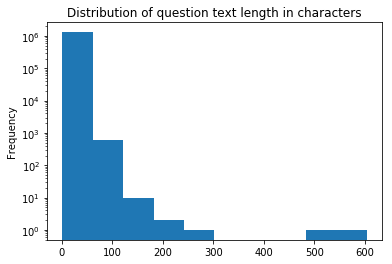

In [8]:
train['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters');

In [9]:
max_len = 72
maxlen = 72
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [10]:
y_train = train['target'].values

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

from sklearn.model_selection import StratifiedKFold
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=10).split(X_train, y_train))

In [12]:
embed_size = 300
embedding_path = "../input/embeddings/glove.840B.300d/glove.840B.300d.txt"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
# all_embs = np.stack(embedding_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std = -0.005838499, 0.48782197
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
        

In [13]:
embedding_path = "../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore') if len(o)>100)
# all_embs = np.stack(embedding_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std = -0.0053247833, 0.49346462
embedding_matrix1 = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix1[i] = embedding_vector
    

In [14]:
embedding_matrix = np.mean([embedding_matrix, embedding_matrix1], axis=0)
del embedding_matrix1

In [15]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)
    
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        hidden_size = 128
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm_attention = Attention(hidden_size*2, maxlen)
        self.gru_attention = Attention(hidden_size*2, maxlen)
        
        self.linear = nn.Linear(1024, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(16, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding, 0)))
        
        h_lstm, _ = self.lstm(h_embedding)
        h_gru, _ = self.gru(h_lstm)
        
        h_lstm_atten = self.lstm_attention(h_lstm)
        h_gru_atten = self.gru_attention(h_gru)
        
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        
        conc = torch.cat((h_lstm_atten, h_gru_atten, avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

In [16]:
m = NeuralNet()

def train_model(model, x_train, y_train, x_val, y_val, validate=True):
    optimizer = torch.optim.Adam(model.parameters())

    # scheduler = CosineAnnealingLR(optimizer, T_max=5)
    # scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean').cuda()
    best_score = -np.inf
    
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        avg_loss = 0.
        
        for x_batch, y_batch in tqdm(train_loader, disable=True):
            y_pred = model(x_batch)
            
            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            
        model.eval()
        
        valid_preds = np.zeros((x_val_fold.size(0)))
        
        if validate:
            avg_val_loss = 0.
            for i, (x_batch, y_batch) in enumerate(valid_loader):
                y_pred = model(x_batch).detach()

                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
            search_result = threshold_search(y_val.cpu().numpy(), valid_preds)

            val_f1, val_threshold = search_result['f1'], search_result['threshold']
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t val_f1={:.4f} best_t={:.2f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_f1, val_threshold, elapsed_time))
        else:
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, elapsed_time))
    
    valid_preds = np.zeros((x_val_fold.size(0)))
    
    avg_val_loss = 0.
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()

        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

    print('Validation loss: ', avg_val_loss)

    test_preds = np.zeros((len(test_loader.dataset)))
    
    for i, (x_batch,) in enumerate(test_loader):
        y_pred = model(x_batch).detach()

        test_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
    # scheduler.step()
    
    return valid_preds, test_preds#, test_preds_local

In [17]:
x_test_cuda = torch.tensor(X_test, dtype=torch.long).cuda()
test = torch.utils.data.TensorDataset(x_test_cuda)
batch_size = 512
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [18]:
seed=1029

def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [19]:
train_preds = np.zeros(len(train))
test_preds = np.zeros((len(test), len(splits)))
n_epochs = 5
from tqdm import tqdm
from sklearn.metrics import f1_score
for i, (train_idx, valid_idx) in enumerate(splits):    
    x_train_fold = torch.tensor(X_train[train_idx], dtype=torch.long).cuda()
    y_train_fold = torch.tensor(y_train[train_idx, np.newaxis], dtype=torch.float32).cuda()
    x_val_fold = torch.tensor(X_train[valid_idx], dtype=torch.long).cuda()
    y_val_fold = torch.tensor(y_train[valid_idx, np.newaxis], dtype=torch.float32).cuda()
    
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    print(f'Fold {i + 1}')
    
    seed_everything(seed + i)
    model = NeuralNet()
    model.cuda()

    valid_preds_fold, test_preds_fold = train_model(model,
                                                                           x_train_fold, 
                                                                           y_train_fold, 
                                                                           x_val_fold, 
                                                                           y_val_fold, validate=False)

    train_preds[valid_idx] = valid_preds_fold
    test_preds[:, i] = test_preds_fold


Fold 1
Epoch 1/5 	 loss=0.1324 	 time=314.56s
Epoch 2/5 	 loss=0.1151 	 time=314.54s
Epoch 3/5 	 loss=0.1085 	 time=312.72s
Epoch 4/5 	 loss=0.1016 	 time=310.76s
Epoch 5/5 	 loss=0.0947 	 time=306.06s
Validation loss:  0.10253760519329473
Fold 2
Epoch 1/5 	 loss=0.1301 	 time=286.81s
Epoch 2/5 	 loss=0.1148 	 time=274.99s
Epoch 3/5 	 loss=0.1080 	 time=275.38s
Epoch 4/5 	 loss=0.1016 	 time=275.89s
Epoch 5/5 	 loss=0.0940 	 time=275.35s
Validation loss:  0.10098556330468403
Fold 3
Epoch 1/5 	 loss=0.1295 	 time=274.72s
Epoch 2/5 	 loss=0.1141 	 time=275.51s
Epoch 3/5 	 loss=0.1070 	 time=274.86s
Epoch 4/5 	 loss=0.1005 	 time=276.37s
Epoch 5/5 	 loss=0.0935 	 time=275.64s
Validation loss:  0.10163183126680334
Fold 4
Epoch 1/5 	 loss=0.1296 	 time=276.19s
Epoch 2/5 	 loss=0.1143 	 time=275.43s
Epoch 3/5 	 loss=0.1080 	 time=275.44s
Epoch 4/5 	 loss=0.1013 	 time=276.02s
Epoch 5/5 	 loss=0.0949 	 time=275.83s
Validation loss:  0.10333259634346614


In [20]:
search_result = threshold_search(y_train, train_preds)
sub['prediction'] = test_preds.mean(1) > search_result['threshold']
sub.to_csv("submission.csv", index=False)